## Selecting genes for a MERFISH gene panel

This notebook shows how to use a reference scRNA-seq dataset and NSForest to identify genes to include in a MERFISH panel in order to resolve the cell types in the MERFISH results.

We will use the mammary gland droplet dataset from Tabula Muris Senis: https://figshare.com/articles/dataset/Processed_files_to_use_with_scanpy_/8273102/2

In [ ]:
import scanpy as sc
adata = sc.read("/storage/RNA_MERFISH/Collaborations/CellSenescence/TabulaMuris/Mammary_Gland_droplet.h5ad")

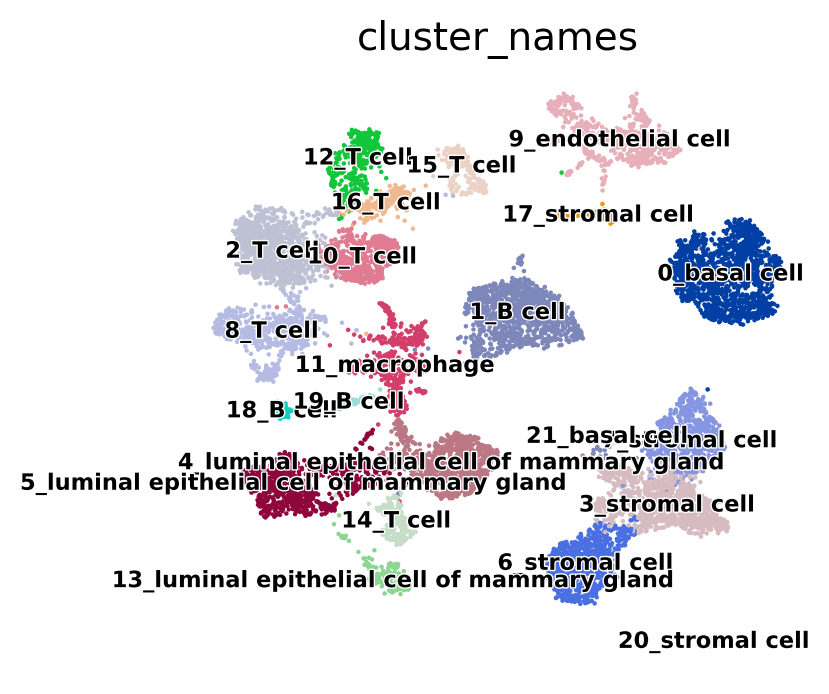

In [116]:
sc.set_figure_params(facecolor="w", dpi=100)
sc.pl.umap(adata, color="cluster_names", legend_loc="on data", legend_fontsize="xx-small", legend_fontoutline=True, frameon=False)

We will use the "cluster_names" annotation for this example. First, we will run NSForest. If the count matrix is stored in the scanpy object as a sparse matrix, NSForest will generate an error, so we first need to convert it to a dense matrix.

In [14]:
adata.X

<11392x19860 sparse matrix of type '<class 'numpy.float32'>'
	with 22792088 stored elements in Compressed Sparse Row format>

In [15]:
adata.X = adata.X.toarray()

There is also an NSForest error that can occur with certain gene names. One way to address this is to keep re-running NSForest and adding the genes it gives an error on one-by-one to the "bad_genes" list below, however that can be a slow process. It doesn't seem to like the group of genes with names such as "2010001M09Rik", so below we just remove all such genes.

In [16]:
bad_genes = ["2010001M09Rik"]
genes = [x for x in adata.var_names if x not in bad_genes and not x.endswith("Rik")]
adata = adata[:, genes]

Make sure NSForest_v3.py is in the same folder as this notebook. It can be downloaded here: https://github.com/JCVenterInstitute/NSForest

Some parameters can be changed in the NS_Forest function:
  - Median_Expression_Level (default 0). This is a cutoff for median expression level to remove negative markers. Negative markers may be useful for clustering, though!
  - Genes_to_testing (default 6). This is how many top genes will be considered for selecting the best set of markers. Every permutation of these genes is tested, so raising the number will increase the runtime exponentially.
  - betaValue (default 0.5). This is the beta value for the f-measure. 1 means precision and recall are weighted equally. Closer to 0 weights precision more and greater than 0 weights towards recall.

In [ ]:
from NSForest_v3 import NS_Forest

adata_markers = NS_Forest(adata, clusterLabelcolumnHeader="cluster_names")

In the NSForest result, the NSForest_Markers column contains what NSForest considers to be the minimal set of genes necessary to differentiate the clusters, while the f-measure column is the accuracy of these markers for each cluster. The final column "Binary_Genes" contains the top genes that differentiated the cluster when considered independently of each other. These were what were tested to find the best combination for the NSForest_Markers column.

In [18]:
adata_markers

,clusterName,f-measure,markerCount,NSForest_Markers,True Positive,True Negative,False Positive,False Negative,1,2,3,4,5,6,index,Binary_Genes
0,0_basal cell,0.980783,2,"[Krt14, Acta2]",1378.0,9927.0,16.0,71.0,Krt14,Acta2,,,,,0_basal cell&Krt14>=1.7194600105285645&Acta2>=...,"[Col9a2, Krt17, Krt5, Cxcl14, Krt14, Acta2, Ta..."
1,10_T cell,0.560000,2,"[Dapl1, Cd3g]",168.0,10777.0,71.0,376.0,Dapl1,Cd3g,,,,,10_T cell&Dapl1>=2.660470962524414&Cd3g>=2.809...,"[Dapl1, Hspa1a, Cd8b1, Cd3g, Cd3e, Cd3d, Coro1..."
2,11_macrophage,0.720748,2,"[Alox5ap, Cfp]",239.0,10825.0,45.0,283.0,Alox5ap,Cfp,,,,,11_macrophage&Alox5ap>=0.917403906583786&Cfp>=...,"[Alox5ap, Lyz1, Lyz2, Mpeg1, Plbd1, Cfp, Ccl9,..."
3,12_T cell,0.789474,2,"[Cxcr6, Icos]",141.0,11084.0,7.0,160.0,Cxcr6,Icos,,,,,12_T cell&Cxcr6>=6.030929327011108&Icos>=8.281...,"[Cxcr6, Actn2, Ccr2, Furin, Icos, Ramp3, Il7r,..."
4,13_luminal epithelial cell of mammary gland,0.738523,2,"[Krt6a, Ppp1r14c]",74.0,11202.0,5.0,111.0,Krt6a,Ppp1r14c,,,,,13_luminal epithelial cell of mammary gland&Kr...,"[Krt6a, Aldh3a1, Ppp1r14c, Ghr, Cldn10, F3, Da..."
5,14_T cell,0.858748,2,"[Apol7c, H2-M2]",107.0,11209.0,4.0,72.0,Apol7c,H2-M2,,,,,14_T cell&Apol7c>=4.285170078277588&H2-M2>=4.8...,"[Ccl22, Apol7c, H2-M2, Cacnb3, Nudt17, Rogdi, ..."
6,15_T cell,0.931373,3,"[Glycam1, Cd3d, Rps16]",133.0,11213.0,1.0,45.0,Glycam1,Cd3d,Rps16,,,,15_T cell&Glycam1>=9.890417098999023&Cd3d>=2.3...,"[Glycam1, Lck, Cd3d, Rps15a-ps4, Rps15a, Rps16..."
7,16_T cell,0.790514,2,"[Tnfrsf4, Ikzf2]",80.0,11224.0,6.0,82.0,Tnfrsf4,Ikzf2,,,,,16_T cell&Tnfrsf4>=8.367594718933105&Ikzf2>=5....,"[Tnfrsf4, Foxp3, Ikzf2, Tnfrsf18, Stx11, Folr4..."
8,17_stromal cell,0.873786,1,[Myl9],72.0,11280.0,4.0,36.0,Myl9,,,,,,17_stromal cell&Myl9>=7.554762363433838,"[Pcp4l1, Nrip2, Ppp1r14a, Myl9, S1pr3, Des, Mu..."
9,18_B cell,0.878963,2,"[Glycam1, Cd79a]",61.0,11310.0,7.0,14.0,Glycam1,Cd79a,,,,,18_B cell&Glycam1>=9.848810195922852&Cd79a>=1....,"[Scd1, H2-Ob, Glycam1, Faim3, H2-DMa, Cd79a, C..."


Now we want to validate this result. We can do this by subsetting our original reference dataset to only these marker genes to simulate a MERFISH experiment, and then check how well the original clusters are preserved.

In [104]:
from functools import reduce
markers = reduce(lambda x, y: x+y, adata_markers["NSForest_Markers"])
markers = list(set(markers))  # Remove any duplicates

In [105]:
len(markers)

43

In [106]:
test = adata[:,markers].copy()

In [107]:
sc.tl.pca(test)
sc.pp.neighbors(test)
sc.tl.umap(test, min_dist=0.3)

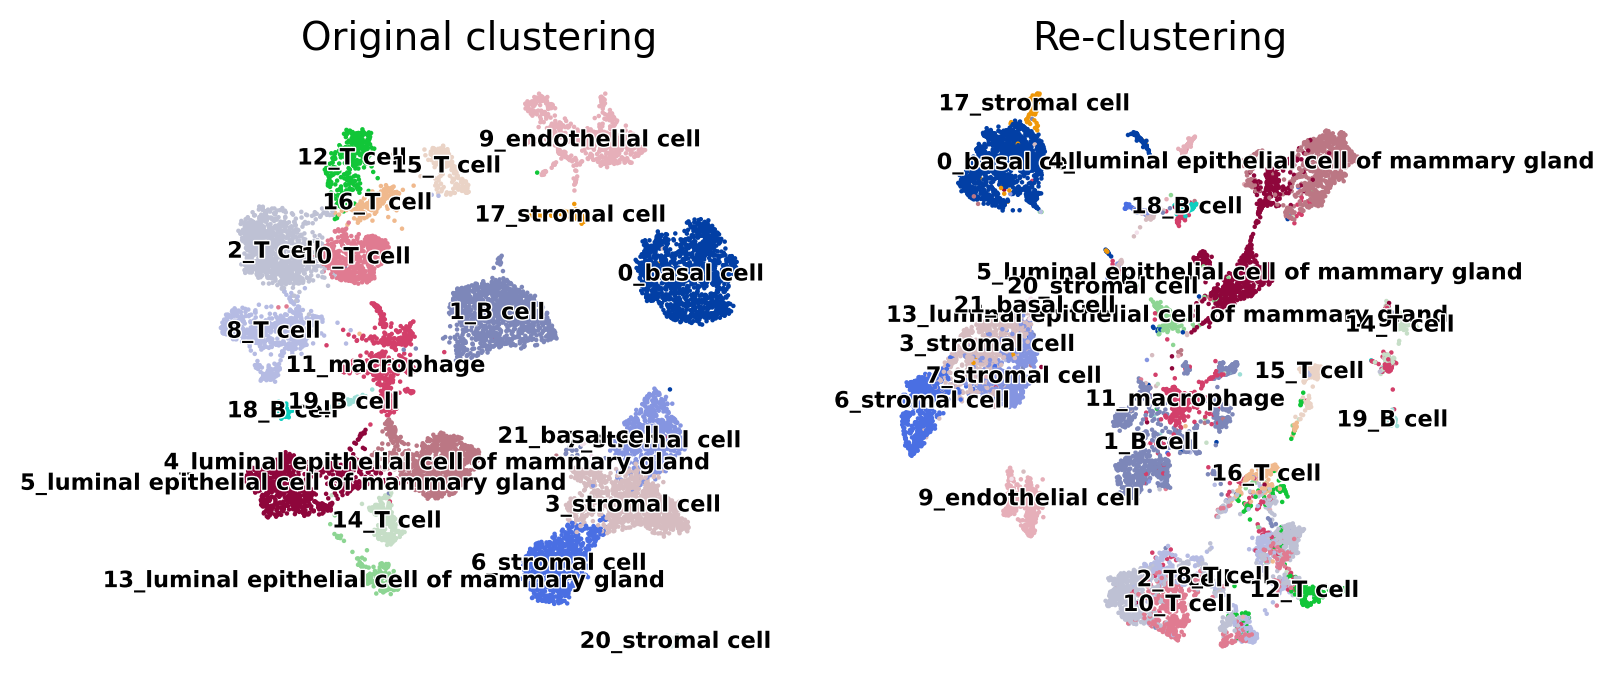

In [108]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(8,4))
sc.pl.umap(adata, color="cluster_names", title="Original clustering", legend_loc="on data", legend_fontsize="xx-small", legend_fontoutline=True, frameon=False, ax=ax[0], show=False)
sc.pl.umap(test, color="cluster_names", title="Re-clustering", legend_loc="on data", legend_fontsize="xx-small", legend_fontoutline=True, frameon=False, ax=ax[1], show=False);

In the UMAP plots above, we can see that some clusters such as 9_endothelial cell remain well separated in the re-clustering, however other clusters may have potential problems. For example cluster 17_stromal cell and 0_basal cell may be difficult to separate.

To quantify the difference between the original and re-clustering, we can use the silhouette score.

In [109]:
from sklearn.metrics import silhouette_score, silhouette_samples

test.obs["silhouette_score"] = silhouette_samples(test.obsm["X_pca"], test.obs["cluster_names"])

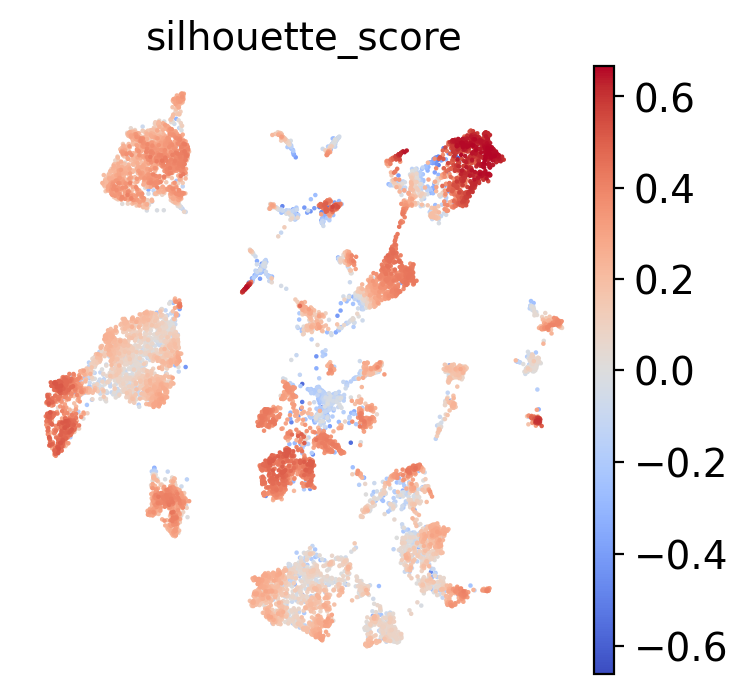

In [110]:
sc.pl.umap(test, color="silhouette_score", frameon=False, cmap="coolwarm", vcenter=0)

A silhouette score above 0 means that cell is closer on average to other cells in its cluster than to cells in the nearest neighboring cluster. Let's find the average silhouette score per cluster.

In [111]:
test_sils = test.obs.groupby("cluster_names").mean()["silhouette_score"].sort_values()
test_sils

cluster_names
11_macrophage                                 -0.166316
8_T cell                                      -0.014398
3_stromal cell                                 0.047796
7_stromal cell                                 0.100698
10_T cell                                      0.118983
13_luminal epithelial cell of mammary gland    0.124980
15_T cell                                      0.125226
12_T cell                                      0.134146
2_T cell                                       0.138142
14_T cell                                      0.142750
17_stromal cell                                0.167218
5_luminal epithelial cell of mammary gland     0.189672
9_endothelial cell                             0.200774
16_T cell                                      0.229811
0_basal cell                                   0.236031
21_basal cell                                  0.255785
6_stromal cell                                 0.322757
1_B cell                          

Now we can see which clusters are the most problematic. With this gene list, we may have trouble separating cells in the 11_macrophage cluster from other clusters. But we should compare this with silhouette scores from the original clustering, as that may not have been perfect either.

In [112]:
adata.obs["silhouette_score"] = silhouette_samples(adata.obsm["X_pca"], adata.obs["cluster_names"])

In [113]:
import pandas as pd
adata_sils = adata.obs.groupby("cluster_names").mean()["silhouette_score"].sort_values()
sils = pd.DataFrame([adata_sils, test_sils], index=["Original", "MERFISH"]).T
sils["Loss"] = sils["Original"] - sils["MERFISH"]
sils.sort_values(by="MERFISH")

,Original,MERFISH,Loss
cluster_names,,,
11_macrophage,-0.015457,-0.166316,0.150859
8_T cell,0.097721,-0.014398,0.112120
3_stromal cell,0.155432,0.047796,0.107636
7_stromal cell,0.204229,0.100698,0.103532
10_T cell,0.274723,0.118983,0.155740
13_luminal epithelial cell of mammary gland,0.334078,0.124980,0.209099
15_T cell,0.125604,0.125226,0.000378
12_T cell,0.263566,0.134146,0.129420
2_T cell,0.279595,0.138142,0.141453


The 11_macrophage cluster had the lowest silhouette score in the original clustering as well. The performance of this gene list can be summarized into a single metric by adding all the differences between per-cluster silhouette scores.

In [114]:
sils["Loss"].sum()

2.144974

Let's try using the Binary_Genes from NSForest instead and see if the result is better.

In [81]:
from functools import reduce
markers = reduce(lambda x, y: list(x)+list(y), adata_markers["Binary_Genes"])
markers = list(set(markers))  # Remove any duplicates

In [82]:
len(markers)

204

In [83]:
test = adata[:,markers].copy()

In [84]:
sc.tl.pca(test)
sc.pp.neighbors(test)
sc.tl.umap(test, min_dist=0.3)

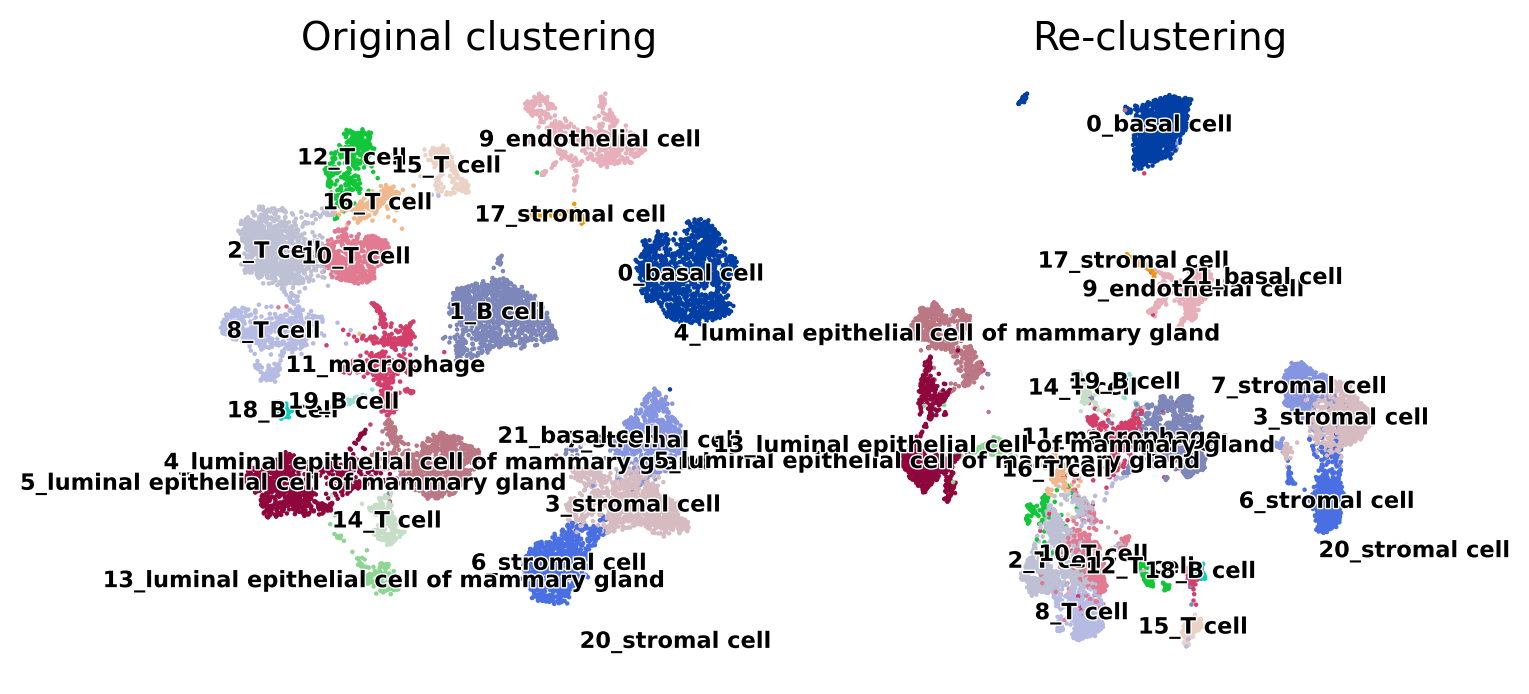

In [85]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(8,4))
sc.pl.umap(adata, color="cluster_names", title="Original clustering", legend_loc="on data", legend_fontsize="xx-small", legend_fontoutline=True, frameon=False, ax=ax[0], show=False)
sc.pl.umap(test, color="cluster_names", title="Re-clustering", legend_loc="on data", legend_fontsize="xx-small", legend_fontoutline=True, frameon=False, ax=ax[1], show=False);

In [86]:
from sklearn.metrics import silhouette_score, silhouette_samples

test.obs["silhouette_score"] = silhouette_samples(test.obsm["X_pca"], test.obs["cluster_names"])

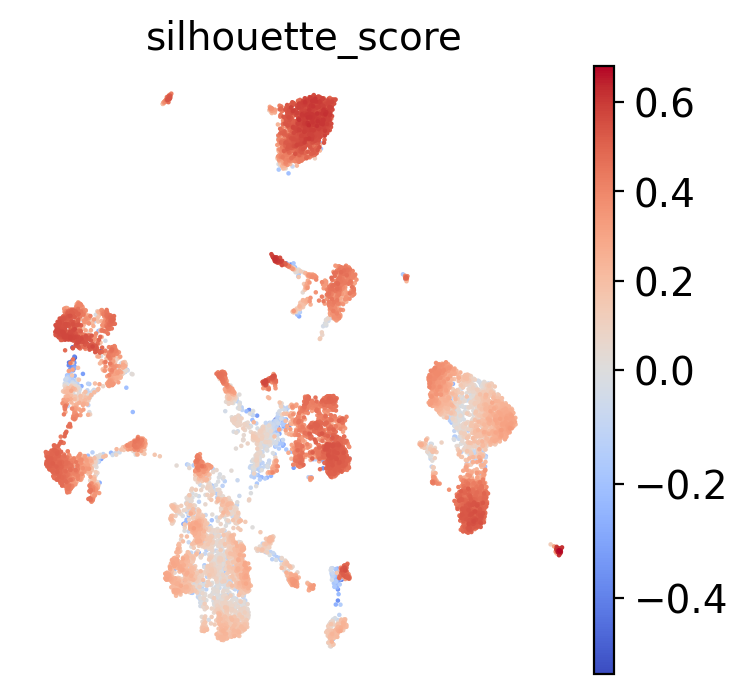

In [87]:
sc.pl.umap(test, color="silhouette_score", frameon=False, cmap="coolwarm", vcenter=0)

In [90]:
test_sils = test.obs.groupby("cluster_names").mean()["silhouette_score"].sort_values()
sils = pd.DataFrame([adata_sils, test_sils], index=["Original", "MERFISH"]).T
sils["Loss"] = sils["Original"] - sils["MERFISH"]
sils.sort_values(by="MERFISH")

,Original,MERFISH,Loss
cluster_names,,,
11_macrophage,-0.015457,-0.066147,0.050690
8_T cell,0.097721,0.065990,0.031732
12_T cell,0.263566,0.118317,0.145249
3_stromal cell,0.155432,0.120713,0.034720
2_T cell,0.279595,0.130157,0.149437
15_T cell,0.125604,0.132801,-0.007198
10_T cell,0.274723,0.138944,0.135779
7_stromal cell,0.204229,0.217068,-0.012839
16_T cell,0.342089,0.241534,0.100556


In [94]:
sils["Loss"].sum()

0.63933223

This has significantly reduced the total loss of silhouette score, but at the expense of needing over 200 genes. Further experimenting could be done to find the best trade-off between the number of genes and silhouette score loss, such as only adding more genes for the Binary_Genes column for the clusters with the highest silhouette score. Alternative methods of selecting genes could be used as well, such as the rank_genes_groups scanpy function to identify differentially expressed genes between clusters.